# Explore here

In [4]:
pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Your code here

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy._core.defchararray import upper

from scipy.stats import chi2_contingency
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_regression, SelectKBest, chi2

import json
import pickle
import os
from pickle import dump

import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn


# Recopilacion de los datos

In [5]:
total_data= pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv")
Raw_data= total_data.copy()
Raw_data.to_excel("/workspaces/Marcos-J-Gomes_https-github.com-4GeeksAcademy-machine-learning-python_LinealRegression/data/raw/Raw_data.xlsx", index = False)

In [6]:
print(total_data.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


# Definicion de variables

age= Edad del beneficiario principal (numérico)  
sex= Género del beneficiario principal (categórico)  
bmi= índice de masa corporal (numérico)  
children= Número de niños/dependientes cubiertos por un seguro médico (numérico)  
smoker= ¿Es fumador? (categórico)  
region= Área residencial del beneficiario en USA: noreste, sureste, suroeste, noroeste (categórico)  
charges= Prima del seguro médico (numérico)  

In [7]:
print(total_data.shape)
print(total_data.info())

(1338, 7)
<class 'pandas.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   str    
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   str    
 5   region    1338 non-null   str    
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), str(3)
memory usage: 73.3 KB
None


# Primeras conclusiones

Tenemos un dataset formado por 7 columnas y 1338 filas  
No se observan valores nulos a simple vista en ninguna variable  
Las variables se dividen en:  
3 categoricas: "sex", "smoker", "region"  
4 numericas: "age", "bmi", "children", "charges"

# Eliminamos duplicados

In [8]:
total_data = total_data.drop_duplicates().reset_index(drop = True)
total_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Analisis Univariable

Categorico

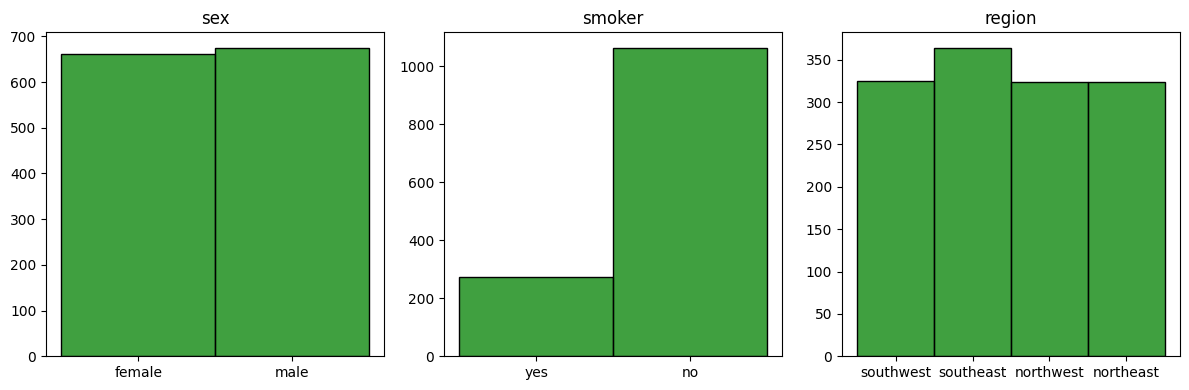

In [9]:
Col_categoricas = ["sex", "smoker", "region"]
fig, axis = plt.subplots(1, 3, figsize=(12, 4))
axis = axis.flatten()  

for i, col in enumerate(Col_categoricas): 
    sns.histplot(data=total_data, x=col, ax=axis[i], color="green")
    axis[i].set_title(col)
    axis[i].set_xlabel(None)
    axis[i].set_ylabel(None)

    if total_data[col].nunique() > 7:
        axis[i].tick_params(axis="x", rotation=90)

for j in range(len(Col_categoricas), len(axis)):
    fig.delaxes(axis[j])
    
plt.tight_layout()
plt.show()


Vemos una cantidad de muestra bastante balanceada en las variables "sex" y "region"  
En su lugar la variable "smoker" si prensenta una gran diferencia en el muestreo

Numerica

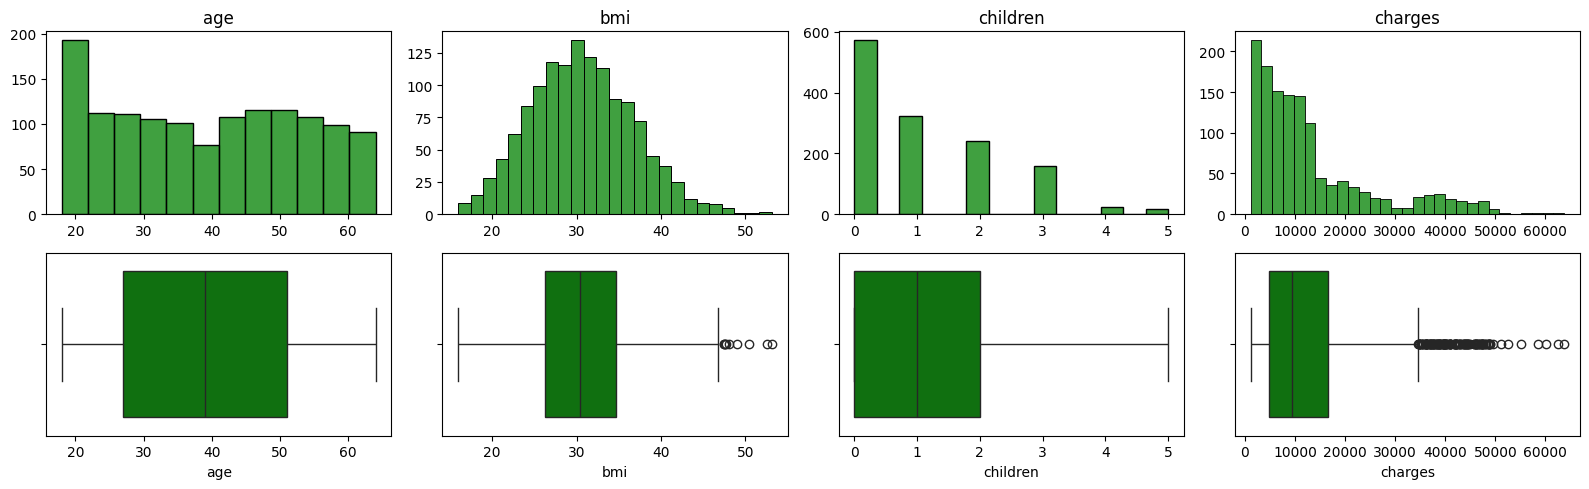

In [10]:
Col_numericas = ["age", "bmi", "children", "charges"]
n = len(Col_numericas)
fig, axis = plt.subplots(2, n, figsize=(4*n, 5))

for i, col in enumerate(Col_numericas):

    sns.histplot(data=total_data, x=col, ax=axis[0, i], color="green")
    axis[0, i].set_title(col)
    axis[0, i].set_xlabel(None)
    axis[0, i].set_ylabel(None)

    sns.boxplot(data=total_data, x=col, ax=axis[1, i],color="green")

for j in range(len(Col_numericas), len(axis)):
    fig.delaxes(axis[j])
    
plt.tight_layout()
plt.show()

- "age" en principio mantiene una buena distribucion entre todas su medidas solo resaltando el tramo de los 20 años que esta muy por encima del resto
- Notamos una "curva de normalidad" en la variable "bmi"
- Como era de esperar notamos una disminución progresiva en la variable "children" ya que cada vez es menos habitual ver familias numerosas
- "Charges" presenta muchos outliners

# Analisis multivariable

Numerico - Numerico

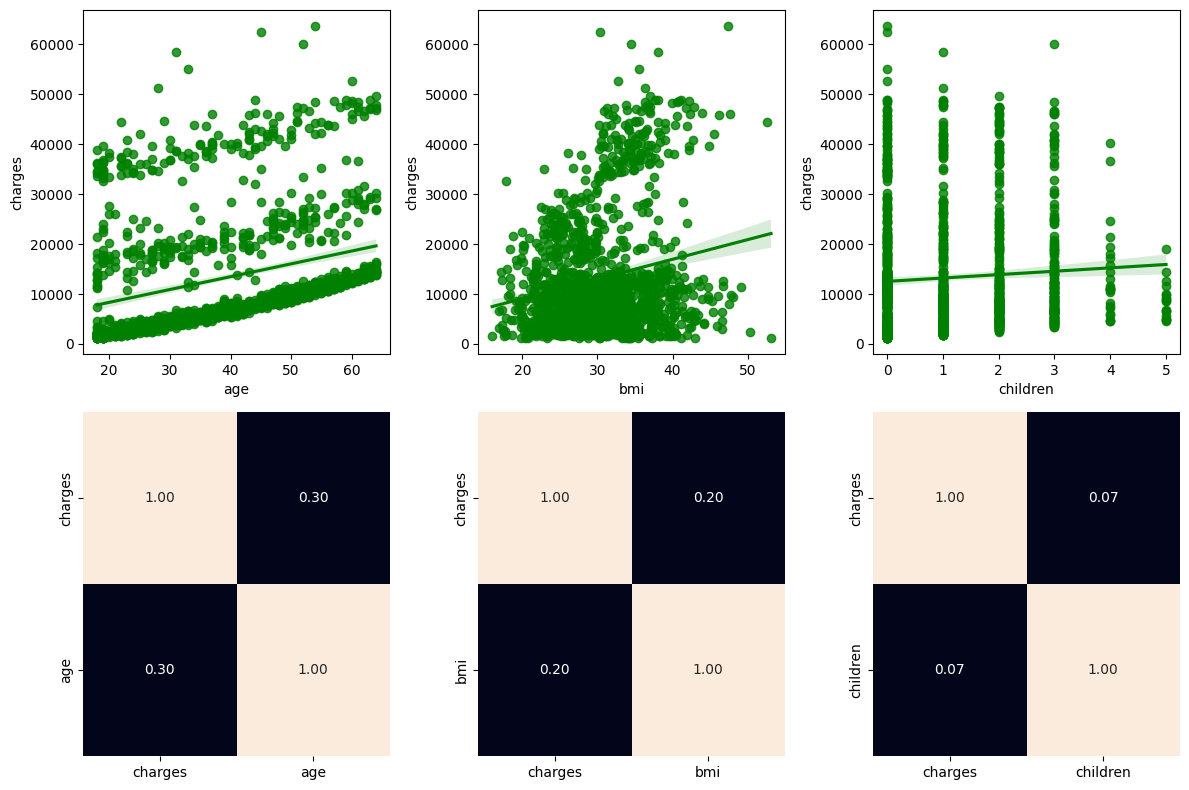

In [11]:
predictora= "charges"
col_num = [c for c in Col_numericas if c != predictora]
n = len(col_num)

fig, axis = plt.subplots(2, n, figsize = (n*4, 8))

for i, col in enumerate(col_num):  
    sns.regplot(ax = axis[0,i], data = total_data, x = col, y = predictora, color="green")
    sns.heatmap(total_data[[predictora, col]].corr(), annot = True, fmt = ".2f", ax = axis[1,i], cbar = False)

plt.tight_layout()
plt.show()

Notamos un ligera relación entre "age" y nuestra variable objetivo "charge"   
La relacion entre "charges" y "children" es muy debil, mantendremos la variable al ser un modelo pequeño pero no parece que tenga mayor peso en este

Categorica-Categorica

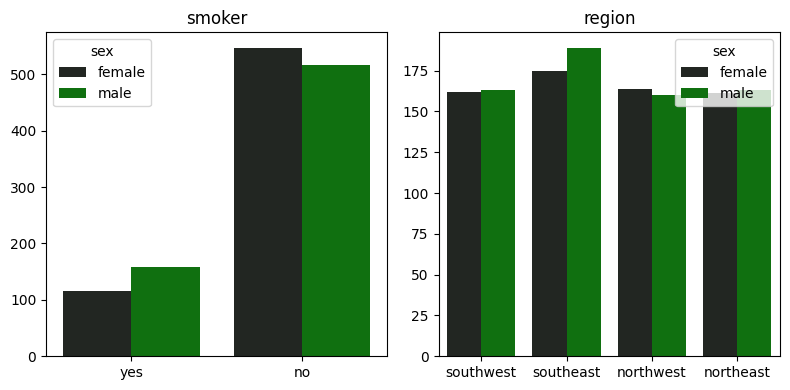

In [12]:
Col_cat = [c for c in Col_categoricas if c != "sex"]
n_c= len(Col_cat)

fig, axis = plt.subplots(1, n_c, figsize=(n_c*4, 4))
axis = axis.flatten()  

for i, col in enumerate(Col_cat): 
    sns.countplot(data = total_data, x = col, hue="sex", ax=axis[i], color="green")
    axis[i].set_title(col)
    axis[i].set_xlabel("")
    axis[i].set_ylabel("")

plt.tight_layout()
plt.show()

Vemos que la variable "sex" se mantiene en balance en nuesto dataset tanto para los fumadores como en la distribución regional

# Analisis de Correlacion

In [13]:
Direccion_guardado = "/workspaces/Marcos-J-Gomes_https-github.com-4GeeksAcademy-machine-learning-python_LinealRegression/data/processed"
os.makedirs(Direccion_guardado, exist_ok=True)

for col in Col_categoricas:
    # Factorizar
    total_data[f"{col}_n"], uniques = pd.factorize(total_data[col])
    
    # Crear diccionario {valor original : código numérico}
    transformation_rules = {str(val): int(code) for code, val in enumerate(uniques)}
    
    # Guardar JSON
    path = os.path.join(Direccion_guardado, f"{col}_transformation_rules.json")
    with open(path, "w") as f:
        json.dump(transformation_rules, f, indent=4)

In [14]:
total_data

,age,sex,bmi,children,smoker,region,charges,sex_n,smoker_n,region_n
0,19,female,27.900,0,yes,southwest,16884.92400,0,0,0
1,18,male,33.770,1,no,southeast,1725.55230,1,1,1
2,28,male,33.000,3,no,southeast,4449.46200,1,1,1
3,33,male,22.705,0,no,northwest,21984.47061,1,1,2
4,32,male,28.880,0,no,northwest,3866.85520,1,1,2
...,...,...,...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830,1,1,2
1333,18,female,31.920,0,no,northeast,2205.98080,0,1,3
1334,18,female,36.850,0,no,southeast,1629.83350,0,1,1
1335,21,female,25.800,0,no,southwest,2007.94500,0,1,0


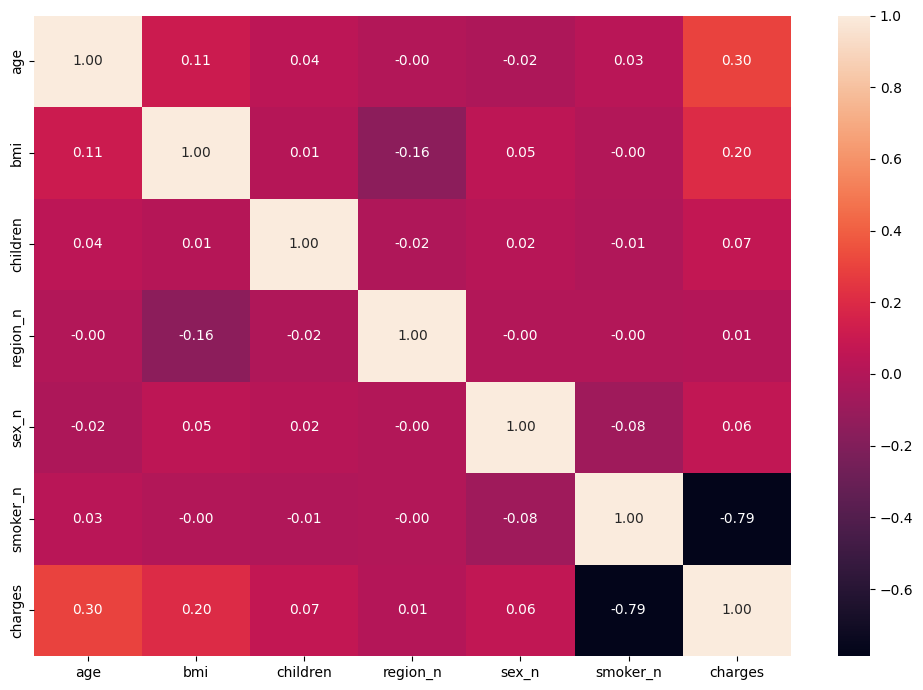

In [15]:
num_variables= ["age", "bmi", "children", "region_n", "sex_n", "smoker_n", "charges"]

fig, axes = plt.subplots(figsize=(10, 7))

sns.heatmap(total_data[num_variables].corr(), annot = True, fmt = ".2f")

plt.tight_layout()
plt.show()

- Vemos que nuestra correlacion positiva más alta con la variable objetivo es "age" aunque no posea un valor tan alto
- La variable que más se relaciona con nuetra variable objetivo es "smoker" aunque sea negativamente

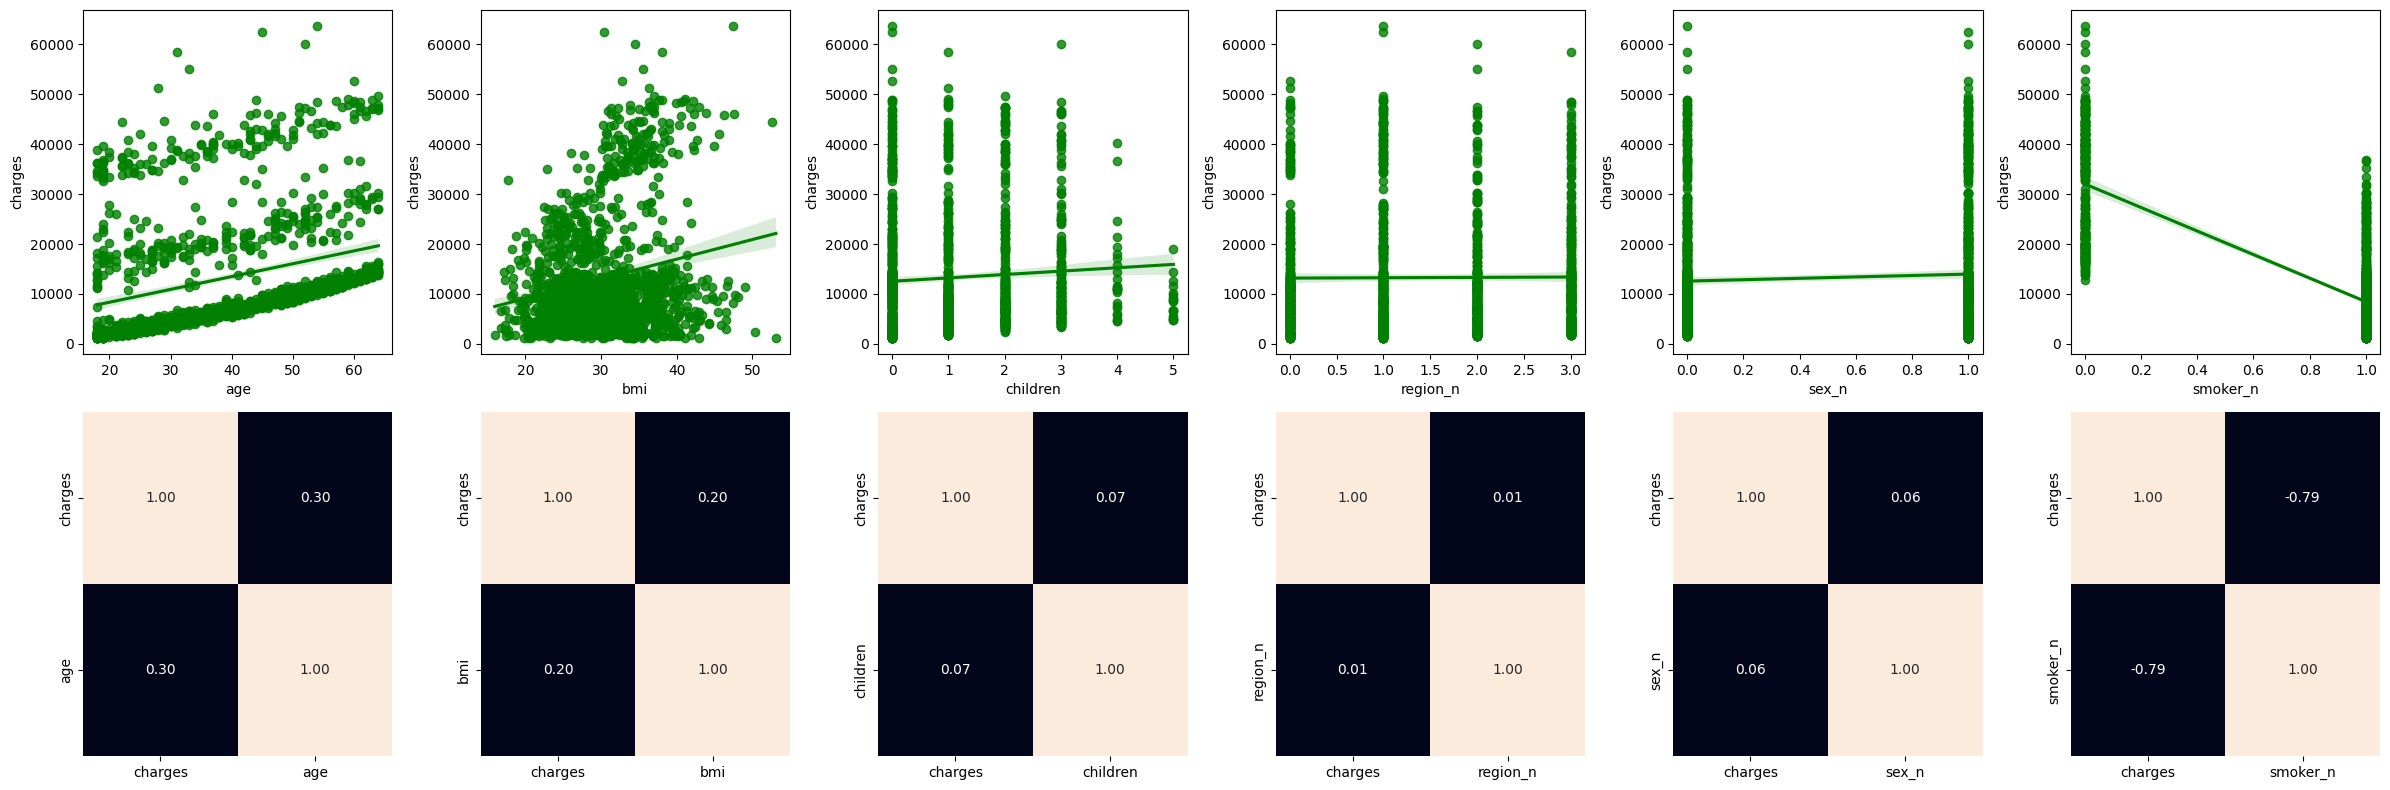

In [16]:
predictora= "charges"
col_num_ = [c for c in num_variables if c != predictora]
n = len(col_num_)

fig, axis = plt.subplots(2, n, figsize = (n*4, 8))

for i, col in enumerate(col_num_):  
    sns.regplot(ax = axis[0,i], data = total_data, x = col, y = predictora, color="green")
    sns.heatmap(total_data[[predictora, col]].corr(), annot = True, fmt = ".2f", ax = axis[1,i], cbar = False)

plt.tight_layout()
plt.show()

# Analisis de toda la data conjunta

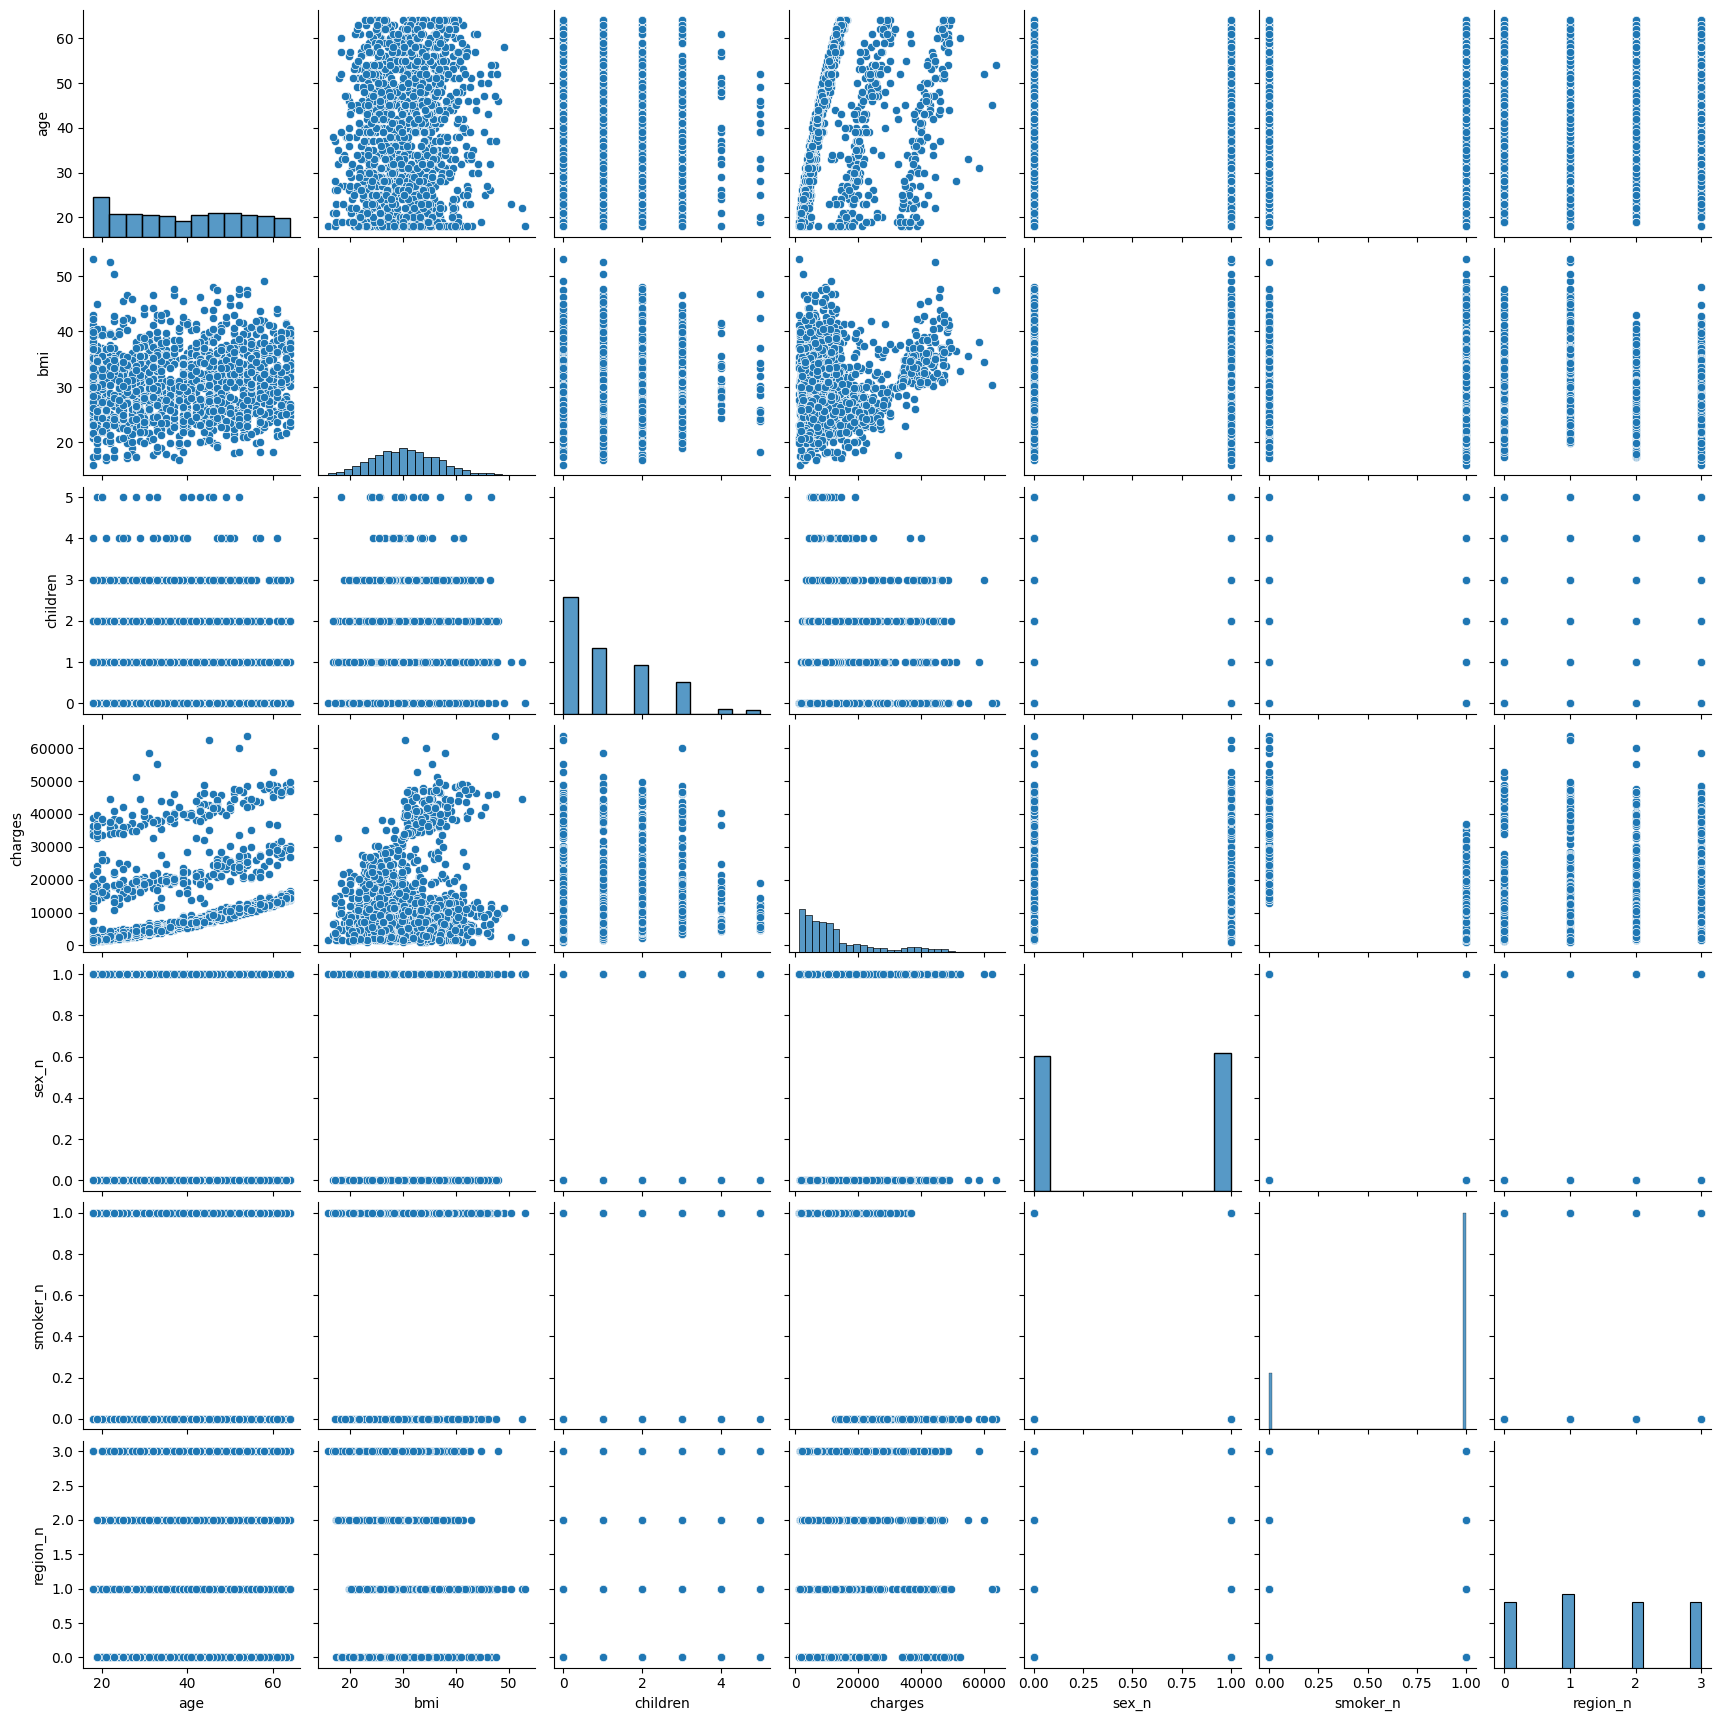

In [17]:
sns.pairplot(data = total_data)

# Feature Engineering

In [18]:
columnas_finales= ["age", "bmi", "children", "region_n", "sex_n", "smoker_n", "charges"]
#Nos quedamos con todas las variables ya que al ser un modelo pequeño no presenta mayor inconveniente

total_data= total_data[columnas_finales]
total_data.head()

,age,bmi,children,region_n,sex_n,smoker_n,charges
0,19,27.900,0,0,0,0,16884.92400
1,18,33.770,1,1,1,1,1725.55230
2,28,33.000,3,1,1,1,4449.46200
3,33,22.705,0,2,1,1,21984.47061
4,32,28.880,0,2,1,1,3866.85520


In [19]:
total_data.describe()

,age,bmi,children,region_n,sex_n,smoker_n,charges
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,1.483919,0.504862,0.795064,13279.121487
std,14.044333,6.100468,1.205571,1.105208,0.500163,0.403806,12110.359656
min,18.000000,15.960000,0.000000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,1.000000,0.000000,1.000000,4746.344000
50%,39.000000,30.400000,1.000000,1.000000,1.000000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,2.000000,1.000000,1.000000,16657.717450
max,64.000000,53.130000,5.000000,3.000000,1.000000,1.000000,63770.428010


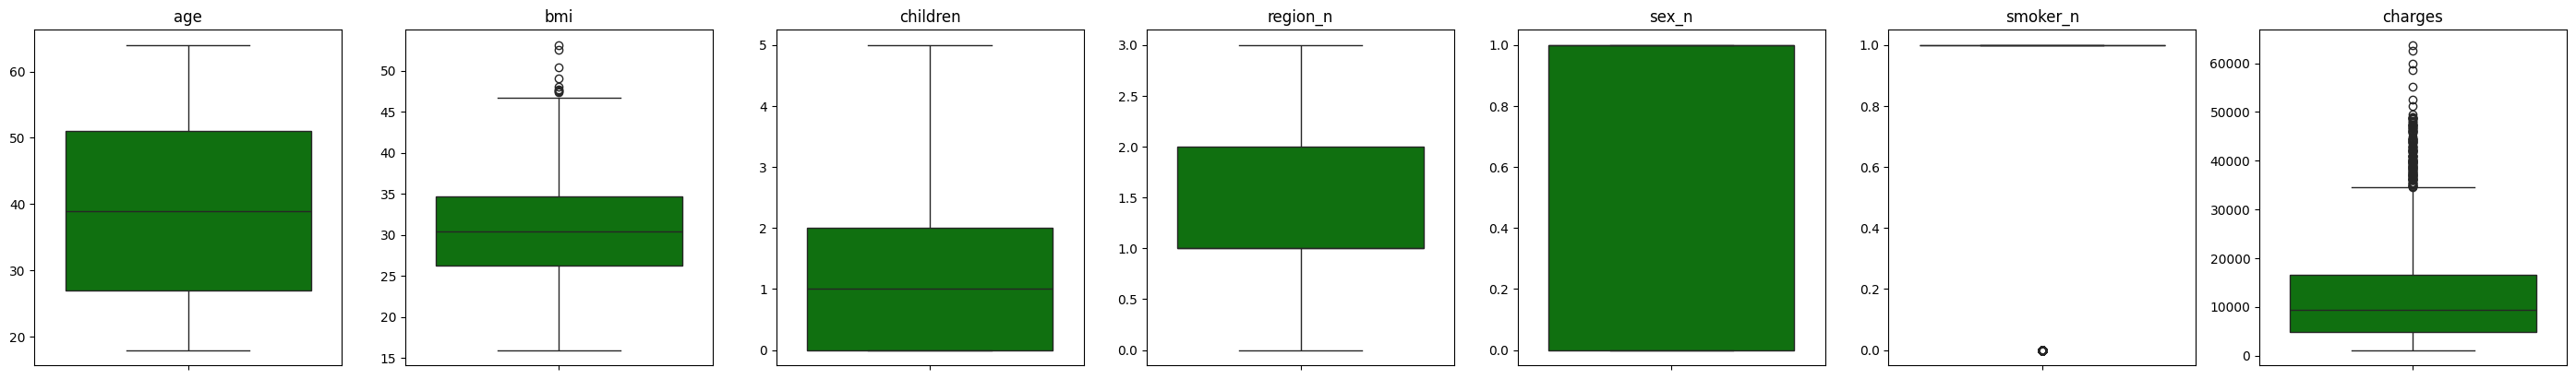

In [20]:
n_f = len(columnas_finales)
fig, axis = plt.subplots(2, n_f, figsize=(n_f*4, 8))
axis = axis.flatten() 

for i, col in enumerate(columnas_finales):
    sns.boxplot(data=total_data, y=col, ax=axis[i],color="green")
    axis[i].set_title(col)
    axis[i].set_xlabel("")
    axis[i].set_ylabel("")

for j in range(len(columnas_finales), len(axis)):
    fig.delaxes(axis[j])
    
plt.tight_layout()
plt.show()

In [21]:
for col in columnas_finales:
    stats = total_data[col].describe()
    
    q1 = stats["25%"]
    q3 = stats["75%"]
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr

    print(f"Los limitires superiores e inferiores de {col} para encontrar outliers son {round(upper_limit, 2)} y {round(lower_limit, 2)}, con un rango intercuartílico de {round(iqr, 2)}")

Los limitires superiores e inferiores de age para encontrar outliers son 87.0 y -9.0, con un rango intercuartílico de 24.0
Los limitires superiores e inferiores de bmi para encontrar outliers son 47.32 y 13.67, con un rango intercuartílico de 8.41
Los limitires superiores e inferiores de children para encontrar outliers son 5.0 y -3.0, con un rango intercuartílico de 2.0
Los limitires superiores e inferiores de region_n para encontrar outliers son 3.5 y -0.5, con un rango intercuartílico de 1.0
Los limitires superiores e inferiores de sex_n para encontrar outliers son 2.5 y -1.5, con un rango intercuartílico de 1.0
Los limitires superiores e inferiores de smoker_n para encontrar outliers son 1.0 y 1.0, con un rango intercuartílico de 0.0
Los limitires superiores e inferiores de charges para encontrar outliers son 34524.78 y -13120.72, con un rango intercuartílico de 11911.37


Limpieza de outliners

In [22]:
total_data = total_data.copy()

total_data_CON_outliers = total_data.copy()
total_data_SIN_outliers = total_data.copy() # Lo vamos a modificar. Para cada variable con outliers, reemplazamos sus valores outliers

outliers_cols = ["bmi"]
# Solo limpiamos los outliners de "bmi" ya que lo otros valores que los presentan son "smoker_n" que se divide solo en 0 y 1. El otro valor seria "charges" pero al ser nuestra variable objetivo lo mejor sera no tocarla

def replace_outliers(column, df):
    stats = df[column].describe()
    iqr = stats["75%"] - stats["25%"]
    
    upper = stats["75%"] + 1.5 * iqr
    lower = stats["25%"] - 1.5 * iqr

    # Evitar límites negativos si la variable no puede ser negativa
    if lower < 0:
        lower = df[column].min()

    # Winsorization vectorizada (rápida)
    df[column] = df[column].clip(lower, upper)

    return df.copy(), [int(round(lower, 2)), int(round(upper, 2))]


outliers_dict = {}
for column in outliers_cols:
    total_data_SIN_outliers, limits = replace_outliers(column, total_data_SIN_outliers)
    outliers_dict[column] = limits

outliers_dict


{'bmi': [13, 47]}

In [23]:
# Guardamos los outliners

with open(f"{Direccion_guardado}/outliers_dict.json", "w") as f:
  json.dump(outliers_dict, f)

Revisamos nulos

In [24]:
total_data_CON_outliers.isnull().sum().sort_values(ascending=False)

age         0
bmi         0
children    0
region_n    0
sex_n       0
smoker_n    0
charges     0
dtype: int64

In [25]:
total_data_SIN_outliers.isnull().sum().sort_values(ascending=False)

age         0
bmi         0
children    0
region_n    0
sex_n       0
smoker_n    0
charges     0
dtype: int64

# Featuring Scaling

In [26]:
# Dividimos en 2 nuestro dataset, Con y Sin Ouliers y a su vez dividimos estos en "Train" y "Test"
 
predictoras = ["age", "bmi", "children", "region_n", "sex_n", "smoker_n"]
target= "charges"

X_CON = total_data_CON_outliers.drop(target, axis = 1)[predictoras]
X_SIN = total_data_SIN_outliers.drop(target, axis = 1)[predictoras]
y = total_data_CON_outliers[target]

X_train_CON_outliers, X_test_CON_outliers, y_train, y_test = train_test_split(X_CON, y, test_size = 0.2, random_state = 42)
X_train_SIN_outliers, X_test_SIN_outliers = train_test_split(X_SIN, test_size = 0.2, random_state = 42)

In [27]:
# TENGO QUE GUARDARME TRES SITUACIONES: 1) DATASET SIN TOCAR, 2) DATASET NORMALIZADO, 3) DATASET MIN-MAX

## NORMALIZACIÓN (ESTANDARIZACIÓN)

### CON OUTLIERS
norm_CON_outliers = StandardScaler()
norm_CON_outliers.fit(X_train_CON_outliers)

X_train_CON_outliers_norm = norm_CON_outliers.transform(X_train_CON_outliers)
X_train_CON_outliers_norm = pd.DataFrame(X_train_CON_outliers_norm, index = X_train_CON_outliers.index, columns = predictoras)

X_test_CON_outliers_norm = norm_CON_outliers.transform(X_test_CON_outliers)
X_test_CON_outliers_norm = pd.DataFrame(X_test_CON_outliers_norm, index = X_test_CON_outliers.index, columns = predictoras)

### SIN OUTLIERS
norm_SIN_outliers = StandardScaler()
norm_SIN_outliers.fit(X_train_SIN_outliers)

X_train_SIN_outliers_norm = norm_SIN_outliers.transform(X_train_SIN_outliers)
X_train_SIN_outliers_norm = pd.DataFrame(X_train_SIN_outliers_norm, index = X_train_SIN_outliers.index, columns = predictoras)

X_test_SIN_outliers_norm = norm_SIN_outliers.transform(X_test_SIN_outliers)
X_test_SIN_outliers_norm = pd.DataFrame(X_test_SIN_outliers_norm, index = X_test_SIN_outliers.index, columns = predictoras)


## ESCALADO MIN-MAX (MINMAXIMIZACIÓN)

### CON OUTLIERS
scaler_CON_outliers = MinMaxScaler()
scaler_CON_outliers.fit(X_train_CON_outliers)

X_train_CON_outliers_scal = scaler_CON_outliers.transform(X_train_CON_outliers)
X_train_CON_outliers_scal = pd.DataFrame(X_train_CON_outliers_scal, index = X_train_CON_outliers.index, columns = predictoras)

X_test_CON_outliers_scal = scaler_CON_outliers.transform(X_test_CON_outliers)
X_test_CON_outliers_scal = pd.DataFrame(X_test_CON_outliers_scal, index = X_test_CON_outliers.index, columns = predictoras)

### SIN OUTLIERS
scaler_SIN_outliers = MinMaxScaler()
scaler_SIN_outliers.fit(X_train_SIN_outliers)

X_train_SIN_outliers_scal = scaler_SIN_outliers.transform(X_train_SIN_outliers)
X_train_SIN_outliers_scal = pd.DataFrame(X_train_SIN_outliers_scal, index = X_train_SIN_outliers.index, columns = predictoras)

X_test_SIN_outliers_scal = scaler_SIN_outliers.transform(X_test_SIN_outliers)
X_test_SIN_outliers_scal = pd.DataFrame(X_test_SIN_outliers_scal, index = X_test_SIN_outliers.index, columns = predictoras)

In [28]:
X_train_CON_outliers.to_excel(f"{Direccion_guardado}/X_train_CON_outliers.xlsx", index = False)
X_train_CON_outliers_norm.to_excel(f"{Direccion_guardado}/X_train_CON_outliers_norm.xlsx", index = False)
X_train_CON_outliers_scal.to_excel(f"{Direccion_guardado}/X_train_CON_outliers_scal.xlsx", index = False)
X_train_SIN_outliers.to_excel(f"{Direccion_guardado}/X_train_SIN_outliers.xlsx", index = False)
X_train_SIN_outliers_norm.to_excel(f"{Direccion_guardado}/X_train_SIN_outliers_norm.xlsx", index = False)
X_train_SIN_outliers_scal.to_excel(f"{Direccion_guardado}/X_train_SIN_outliers_scal.xlsx", index = False)

X_test_CON_outliers.to_excel(f"{Direccion_guardado}/X_test_CON_outliers.xlsx", index = False)
X_test_CON_outliers_norm.to_excel(f"{Direccion_guardado}/X_test_CON_outliers_norm.xlsx", index = False)
X_test_CON_outliers_scal.to_excel(f"{Direccion_guardado}/X_test_CON_outliers_scal.xlsx", index = False)
X_test_SIN_outliers.to_excel(f"{Direccion_guardado}/X_test_SIN_outliers.xlsx", index = False)
X_test_SIN_outliers_norm.to_excel(f"{Direccion_guardado}/X_test_SIN_outliers_norm.xlsx", index = False)
X_test_SIN_outliers_scal.to_excel(f"{Direccion_guardado}/X_test_SIN_outliers_scal.xlsx", index = False)

y_train.to_excel(f"{Direccion_guardado}/y_train.xlsx", index = False)
y_test.to_excel(f"{Direccion_guardado}/y_test.xlsx", index = False)

# SCALERs
with open("/workspaces/Marcos-J-Gomes_https-github.com-4GeeksAcademy-machine-learning-python_LinealRegression/models/norm_CON_outliers.pkl", "wb") as file:
  pickle.dump(norm_CON_outliers, file)
with open("/workspaces/Marcos-J-Gomes_https-github.com-4GeeksAcademy-machine-learning-python_LinealRegression/models/norm_SIN_outliers.pkl", "wb") as file:
  pickle.dump(norm_SIN_outliers, file)
with open("/workspaces/Marcos-J-Gomes_https-github.com-4GeeksAcademy-machine-learning-python_LinealRegression/models/scaler_CON_outliers.pkl", "wb") as file:
  pickle.dump(scaler_CON_outliers, file)
with open("/workspaces/Marcos-J-Gomes_https-github.com-4GeeksAcademy-machine-learning-python_LinealRegression/models/scaler_SIN_outliers.pkl", "wb") as file:
  pickle.dump(scaler_SIN_outliers, file)

# Feacture selection

Con outliers

In [29]:
X_train = X_train_CON_outliers.copy()
X_test = X_test_CON_outliers.copy()

# Con un valor de k = 5 decimos que seleccionamos 4 caracteristicas
selection_model = SelectKBest(f_regression, k = 4)
selection_model.fit(X_train, y_train)

ix = selection_model.get_support()
X_train_sel_CON_outliers = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel_CON_outliers = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

In [30]:
print(X_train_sel_CON_outliers.head()) 

    age     bmi  children  smoker_n
0  23.0  24.510       0.0       1.0
1  21.0  25.745       2.0       1.0
2  52.0  37.525       2.0       1.0
3  63.0  41.470       0.0       1.0
4  47.0  26.600       2.0       1.0


In [31]:
print(X_test_sel_CON_outliers.head())

    age     bmi  children  smoker_n
0  49.0  22.515       0.0       1.0
1  29.0  25.600       4.0       1.0
2  51.0  36.385       3.0       1.0
3  31.0  34.390       3.0       0.0
4  31.0  38.390       2.0       1.0


In [32]:
X_train_sel_CON_outliers[target] = list(y_train)
X_test_sel_CON_outliers[target] = list(y_test)
X_train_sel_CON_outliers.to_csv(f"{Direccion_guardado}/X_train_sel_CON_outliers_clean.csv", index = False)
X_test_sel_CON_outliers.to_csv(f"{Direccion_guardado}/X_test_sel_CON_outliers_clean.csv", index = False)

In [33]:
X_train = X_train_CON_outliers_norm.copy()
X_test = X_test_CON_outliers_norm.copy()

# Con un valor de k = 5 decimos que seleccionamos 4 caracteristicas
selection_model = SelectKBest(f_regression, k = 4)
selection_model.fit(X_train, y_train)

ix = selection_model.get_support()
X_train_sel_CON_outliers_norm = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel_CON_outliers_norm = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

In [34]:
print(X_train_sel_CON_outliers_norm.head()) 

        age       bmi  children  smoker_n
0 -1.157680 -0.996928 -0.907908  0.500292
1 -1.300619 -0.792762  0.766904  0.500292
2  0.914926  1.154664  0.766904  0.500292
3  1.701087  1.806837 -0.907908  0.500292
4  0.557580 -0.651417  0.766904  0.500292


In [35]:
print(X_test_sel_CON_outliers_norm.head()) 

        age       bmi  children  smoker_n
0  0.700518 -1.326734 -0.907908  0.500292
1 -0.728865 -0.816733  2.441716  0.500292
2  0.843457  0.966203  1.604310  0.500292
3 -0.585927  0.636397  1.604310 -1.998831
4 -0.585927  1.297663  0.766904  0.500292


In [36]:
X_train_sel_CON_outliers_norm[target] = list(y_train)
X_test_sel_CON_outliers_norm[target] = list(y_test)
X_train_sel_CON_outliers_norm.to_csv(f"{Direccion_guardado}/X_train_sel_CON_outliers_norm_clean.csv", index = False)
X_test_sel_CON_outliers_norm.to_csv(f"{Direccion_guardado}/X_test_sel_CON_outliers_norm_clean.csv", index = False)

In [37]:
X_train = X_train_CON_outliers_scal.copy()
X_test = X_test_CON_outliers_scal.copy()

# Con un valor de k = 5 decimos que seleccionamos 4 caracteristicas
selection_model = SelectKBest(f_regression, k = 4)
selection_model.fit(X_train, y_train)

ix = selection_model.get_support()
X_train_sel_CON_outliers_scal = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel_CON_outliers_scal = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])


In [38]:
print(X_train_sel_CON_outliers_scal.head())  

        age       bmi  children  smoker_n
0  0.108696  0.230024       0.0       1.0
1  0.065217  0.263250       0.4       1.0
2  0.739130  0.580172       0.4       1.0
3  0.978261  0.686306       0.0       1.0
4  0.630435  0.286252       0.4       1.0


In [39]:
print(X_test_sel_CON_outliers_scal.head()) 

        age       bmi  children  smoker_n
0  0.673913  0.176352       0.0       1.0
1  0.239130  0.259349       0.8       1.0
2  0.717391  0.549502       0.6       1.0
3  0.282609  0.495830       0.6       0.0
4  0.282609  0.603444       0.4       1.0


In [40]:
X_train_sel_CON_outliers_scal[target] = list(y_train)
X_test_sel_CON_outliers_scal[target] = list(y_test)
X_train_sel_CON_outliers_scal.to_csv(f"{Direccion_guardado}/X_train_sel_CON_outliers_scal_clean.csv", index = False)
X_test_sel_CON_outliers_scal.to_csv(f"{Direccion_guardado}/X_test_sel_CON_outliers_scal_clean.csv", index = False)

Sin Outliners

In [41]:
X_train = X_train_SIN_outliers.copy()
X_test = X_test_SIN_outliers.copy()

# Con un valor de k = 5 decimos que seleccionamos 4 caracteristicas
selection_model = SelectKBest(f_regression, k = 4)
selection_model.fit(X_train, y_train)

ix = selection_model.get_support()
X_train_sel_SIN_outliers = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel_SIN_outliers = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

In [42]:
print(X_train_sel_SIN_outliers.head())

    age     bmi  children  smoker_n
0  23.0  24.510       0.0       1.0
1  21.0  25.745       2.0       1.0
2  52.0  37.525       2.0       1.0
3  63.0  41.470       0.0       1.0
4  47.0  26.600       2.0       1.0


In [43]:
print(X_test_sel_SIN_outliers.head()) 

    age     bmi  children  smoker_n
0  49.0  22.515       0.0       1.0
1  29.0  25.600       4.0       1.0
2  51.0  36.385       3.0       1.0
3  31.0  34.390       3.0       0.0
4  31.0  38.390       2.0       1.0


In [44]:
X_train_sel_SIN_outliers[target] = list(y_train)
X_test_sel_SIN_outliers[target] = list(y_test)
X_train_sel_SIN_outliers.to_csv(f"{Direccion_guardado}/X_train_sel_SIN_outliers_clean.csv", index = False)
X_test_sel_SIN_outliers.to_csv(f"{Direccion_guardado}/X_test_sel_SIN_outliers_clean.csv", index = False)

In [45]:
X_train = X_train_SIN_outliers_norm.copy()
X_test = X_test_SIN_outliers_norm.copy()

# Con un valor de k = 5 decimos que seleccionamos 5 caracteristicas
selection_model = SelectKBest(f_regression, k = 4)
selection_model.fit(X_train, y_train)

ix = selection_model.get_support()
X_train_sel_SIN_outliers_norm = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel_SIN_outliers_norm = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

In [46]:
print(X_train_sel_SIN_outliers_norm.head()) 

        age       bmi  children  smoker_n
0 -1.157680 -1.002462 -0.907908  0.500292
1 -1.300619 -0.796635  0.766904  0.500292
2  0.914926  1.166632  0.766904  0.500292
3  1.701087  1.824110 -0.907908  0.500292
4  0.557580 -0.654140  0.766904  0.500292


In [47]:
print(X_test_sel_SIN_outliers_norm.head()) 

        age       bmi  children  smoker_n
0  0.700518 -1.334950 -0.907908  0.500292
1 -0.728865 -0.820801  2.441716  0.500292
2  0.843457  0.976639  1.604310  0.500292
3 -0.585927  0.644150  1.604310 -1.998831
4 -0.585927  1.310794  0.766904  0.500292


In [48]:
X_train_sel_SIN_outliers_norm[target] = list(y_train)
X_test_sel_SIN_outliers_norm[target] = list(y_test)
X_train_sel_SIN_outliers_norm.to_csv(f"{Direccion_guardado}/X_train_sel_SIN_outliers_norm_clean.csv", index = False)
X_test_sel_SIN_outliers_norm.to_csv(f"{Direccion_guardado}/X_test_sel_SIN_outliers_norm_clean.csv", index = False)

In [49]:
X_train = X_train_SIN_outliers_scal.copy()
X_test = X_test_SIN_outliers_scal.copy()

# Con un valor de k = 5 decimos que seleccionamos 5 caracteristicas
selection_model = SelectKBest(f_regression, k = 4)
selection_model.fit(X_train, y_train)

ix = selection_model.get_support()
X_train_sel_SIN_outliers_scal = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel_SIN_outliers_scal = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

In [50]:
print(X_train_sel_SIN_outliers_scal.head())

        age       bmi  children  smoker_n
0  0.108696  0.272684       0.0       1.0
1  0.065217  0.312071       0.4       1.0
2  0.739130  0.687769       0.4       1.0
3  0.978261  0.813586       0.0       1.0
4  0.630435  0.339340       0.4       1.0


In [51]:
print(X_test_sel_SIN_outliers_scal.head()) 

        age       bmi  children  smoker_n
0  0.673913  0.209058       0.0       1.0
1  0.239130  0.307447       0.8       1.0
2  0.717391  0.651411       0.6       1.0
3  0.282609  0.587785       0.6       0.0
4  0.282609  0.715356       0.4       1.0


In [52]:
X_train_sel_SIN_outliers_scal[target] = list(y_train)
X_test_sel_SIN_outliers_scal[target] = list(y_test)
X_train_sel_SIN_outliers_scal.to_csv(f"{Direccion_guardado}/X_train_sel_SIN_outliers_scal_clean.csv", index = False)
X_test_sel_SIN_outliers_scal.to_csv(f"{Direccion_guardado}/X_test_sel_SIN_outliers_scal_clean.csv", index = False)